In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
import os
import time



print(torch.backends.mps.is_available()) 


## TO DO: Modify to work with 'Price' instead of predicting close price! Or just use the close price... whatever we want 



True


In [2]:
aapl = pd.read_csv('AAPL.csv')
tsla = pd.read_csv('TSLA.csv')

In [3]:
data = [tsla]

stock_names = ['Tesla']

data

[            Date        Open        High         Low       Close   Adj Close  \
 0     2018-11-30   22.788668   23.440001   22.550667   23.365334   23.365334   
 1     2018-12-03   24.000000   24.400000   23.466667   23.899332   23.899332   
 2     2018-12-04   23.736668   24.578667   23.466667   23.980000   23.980000   
 3     2018-12-06   23.733999   24.492001   23.384001   24.204000   24.204000   
 4     2018-12-07   24.600000   25.299334   23.843332   23.864668   23.864668   
 ...          ...         ...         ...         ...         ...         ...   
 1252  2023-11-22  242.039993  244.009995  231.399994  234.210007  234.210007   
 1253  2023-11-24  233.750000  238.750000  232.330002  235.449997  235.449997   
 1254  2023-11-27  236.889999  238.330002  232.100006  236.080002  236.080002   
 1255  2023-11-28  236.679993  247.000000  234.009995  246.720001  246.720001   
 1256  2023-11-29  249.210007  252.750000  242.759995  244.139999  244.139999   
 
          Volume  
 0     

In [4]:
def create_lag_variables(df, freq='daily'):
    """
    Create lag variables for stock data.

    :param df: pandas DataFrame with stock data.
    :param freq: Frequency of data aggregation ('daily' or 'monthly').
    :return: DataFrame with new lag variables.
    """
    lag_vars = ['Open', 'High', 'Low', 'Close', 'Volume']
    lag_periods = 14 if freq == 'daily' else 3

    for var in lag_vars:
        for lag in range(1, lag_periods + 1):
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    return df

In [5]:
# Function to create sequences
def create_sequences(features, target, sequence_length=20):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length]) 
        y.append(target[i + sequence_length]) 
    return np.array(X), np.array(y)


In [6]:
def evaluate(model, loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    losses = []

    with torch.no_grad():  # No need to track gradients for testing
        for seq, labels in loader:
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            losses.append(loss.item())

    avg_loss = np.mean(losses)
    return avg_loss

In [7]:
def calculate_metrics(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq).numpy()
            predictions.extend(y_pred)
            actuals.extend(labels.numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    #print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}')
    
    
    return mse, rmse, mae, r2

In [8]:
def plot_predictions1(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq).numpy()
            predictions.extend(y_pred)
            actuals.extend(labels.numpy())

    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'Stock Price Prediction for {stock_names[0]}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Stock Price')
    plt.legend()
    plt.show()

In [9]:
def plot_residuals(model, test_loader):
    model.eval()
    residuals = []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq)
            residuals.extend((labels - y_pred).numpy())

    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title('Residuals of Predictions')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()


In [10]:
'''
def predict(model, loader):
    """
    Predicts outputs for the given data loader using the specified model.

    Parameters:
    model (torch.nn.Module): The trained model for prediction.
    loader (torch.utils.data.DataLoader): DataLoader containing the test dataset.

    Returns:
    numpy.ndarray: An array of predictions.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients for predictions
        for seq in loader:
            y_pred = model(seq)
            predictions.extend(y_pred.cpu().numpy())

    return np.array(predictions)
    
    
'''

def predict(model, loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients for predictions
        for batch in loader:
            # Extracting the sequence from the batch
            if isinstance(batch, list) or isinstance(batch, tuple):
                # Assuming the sequence is the first element of the batch
                seq = batch[0]
            else:
                # If the batch is directly a tensor
                seq = batch

            # Check if seq is a tensor, convert if it's a numpy array
            if isinstance(seq, np.ndarray):
                seq = torch.from_numpy(seq)
            
            # Ensure seq is on the correct device (e.g., GPU if model is on GPU)
            seq = seq.to(next(model.parameters()).device)

            # Get predictions
            y_pred = model(seq)
            predictions.extend(y_pred.cpu().numpy())

    return np.array(predictions)

In [11]:
def stock_lstm(stocks, stock_names, num_epochs, num_layers, num_nodes, lr, cv):
    
    for i, stock_orig in enumerate(stocks):
        
        message = f"\n\n *** LSTM FOR STOCK: {stock_names[i]} with {num_layers} layer(s) and {num_nodes} nodes per layer *** "

        #print(message)
        
        stock = stock_orig.copy(deep=False)
        
        #print(stock)
    
        stock['Date'] = pd.to_datetime(stock['Date'])
        stock['Day'] = stock['Date'].dt.day
        stock['Month'] = stock['Date'].dt.month
        stock['Year'] = stock['Date'].dt.year

        stock.drop('Date', axis=1, inplace=True)

        column_order = ['Day', 'Month', 'Year'] + [col for col in stock if col not in ['Day', 'Month', 'Year']]
        stock = stock[column_order]
        
        stock = create_lag_variables(stock, freq='daily')
        stock = stock.dropna()

        stock = stock.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    
        
    
        # Separate the Features from the Target Variable 

        features = stock.drop(['Close'], axis = 1)
        target = stock['Close']
        
        
        # Scale / Normalize the Data

        scaler_features = MinMaxScaler(feature_range=(0, 1))
        scaled_features = scaler_features.fit_transform(features)

        scaler_target = MinMaxScaler(feature_range=(0, 1))
        scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))
        
        # Create sequences
        sequence_length = 20  # 20 business days
        X, y = create_sequences(scaled_features, scaled_target, sequence_length)
        
        
        # Determine the indices for splitting the data
        total_size = len(X)
        test_size = int(total_size * 0.2)  # This is going to SERIOIUSLY over fit but want a 14 day forecast ... might not be the best way to get that, 
        val_size = int(total_size * 0.2)  # And another 20% for validation

        # Create temporal splits
        X_train = X[:total_size - (test_size + val_size)]
        y_train = y[:total_size - (test_size + val_size)]

        X_val = X[total_size - (test_size + val_size):total_size - test_size]
        y_val = y[total_size - (test_size + val_size):total_size - test_size]

        X_test = X[total_size - test_size:]
        y_test = y[total_size - test_size:]
        
        
        
        class StockPriceLSTM(nn.Module):
            def __init__(self, input_size, hidden_layer_size=num_nodes, output_size=1, num_layers = num_layers):
                super(StockPriceLSTM, self).__init__()
                self.hidden_layer_size = hidden_layer_size
                self.num_layers = num_layers

                # LSTM layer
                self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

                # Linear layer to get to the output size
                self.linear = nn.Linear(hidden_layer_size, output_size)

            def forward(self, input_seq):
                # Initializing hidden state for first input with zeros
                h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
                c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

                # Forward propagate the LSTM
                lstm_out, _ = self.lstm(input_seq, (h0, c0))

                # Pass the output of the last time step to the linear layer
                predictions = self.linear(lstm_out[:, -1, :])
                return predictions

            
            
        # Assuming the number of features in your data is correctly set
        num_features = X_train.shape[2]  # Number of features in the training data
        
        
        
        # Convert data to PyTorch tensors
        X_train_tensors = torch.Tensor(X_train)
        y_train_tensors = torch.Tensor(y_train)
        X_val_tensors = torch.Tensor(X_val)
        y_val_tensors = torch.Tensor(y_val)
        X_test_tensors = torch.Tensor(X_test)
        y_test_tensors = torch.Tensor(y_test)
        
        
        class StockDataset(Dataset):
            def __init__(self, X, y):
                self.X = X
                self.y = y

            def __len__(self):
                return len(self.X)

            def __getitem__(self, idx):
                return (self.X[idx].reshape(-1, num_features), self.y[idx])

        # Create datasets
        train_dataset = StockDataset(X_train_tensors, y_train_tensors)
        val_dataset = StockDataset(X_val_tensors, y_val_tensors)    
        test_dataset = StockDataset(X_test_tensors, y_test_tensors)


        batch_size = 64  # You can adjust the batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        

        # Model, Loss function, optimizer 
        model = StockPriceLSTM(input_size=num_features, hidden_layer_size=num_nodes, num_layers=num_layers)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        # Lists to store loss values
        training_loss = []
        validation_loss = []

        epochs = num_epochs # Parameter
        
        # TRAINING LOOP 
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for seq, labels in train_loader:
                #print(seq.shape)
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                                     torch.zeros(1, batch_size, model.hidden_layer_size))
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                single_loss.backward()
                optimizer.step()
                train_losses.append(single_loss.item())

            avg_train_loss = np.mean(train_losses)
            training_loss.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_losses = []
            with torch.no_grad():
                for seq, labels in val_loader:
                    y_pred = model(seq)
                    single_loss = loss_function(y_pred, labels)
                    val_losses.append(single_loss.item())
                avg_val_loss = np.mean(val_losses)
                validation_loss.append(avg_val_loss)
                
            # Not printing the epochs and loss for too big of output 

            #print(f'Epoch {epoch} Training Loss: {avg_train_loss:.8f} Validation Loss: {avg_val_loss:.8f}')

        if not cv:
            
            # Plot Training and Validation Loss 
            plt.plot(training_loss, label='Training Loss')
            plt.plot(validation_loss, label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Validation Losses')
            plt.legend()
            plt.show()
        
            
        
        
            # Test Loss
            final_test_loss = evaluate(model, test_loader, loss_function)
            print(f'Final Test Loss: {final_test_loss:.8f}')


            # Train Loss
            final_train_loss = evaluate(model, train_loader, loss_function)
            print(f'Final Train Loss: {final_train_loss:.8f}')


        
            # Plot Actuals v Predicted 

            plot_predictions(model, test_loader)

            # Plot residuals 

            plot_residuals(model, test_loader)


        
        mse, rmse, mae, r2 = calculate_metrics(model, val_loader)
        
        

    return r2,rmse, model, test_loader,features, scaler_features, scaler_target, total_size, test_size, scaled_features



In [100]:
#stock_lstm(stocks, num_epochs = 150, num_layers = 1, hidden_layer_size = 100, lr = .001)

In [14]:

#grid_lr= [ .005, .003, .001]
#grid_epochs = [50, 75, 100, 135, 150]
#grid_num_layers = [1,2,3,4]
#grid_num_nodes = [50, 75, 100, 150, 200]


grid_lr= [.01]
grid_epochs = [50]
grid_num_layers = [1, 3]
grid_num_nodes = [50, 100]

best_r2 = 0
best_rmse = 10000000000
best_model = None
best_test_loader = None
best_features = None
best_scaler_features = None
best_scaler_target = None
best_total_size = None
best_test_size = None
i = 0

print(f'\n Historical Data LSTM for stock: {stock_names[0]} \n')

start_time = time.time()
for lr in grid_lr:
    for epochs in grid_epochs:
        for num_layers in grid_num_layers:
            for num_nodes in grid_num_nodes:
                
                i += 1
                r2, rmse, model, test_loader, features, scaler_features, scaler_target, total_size, test_size, scaled_features =  stock_lstm(stocks = data, 
                                 stock_names = stock_names, num_epochs = epochs, 
                                 num_layers=num_layers, num_nodes=num_nodes, lr=lr, cv=True)
                
                
                if r2 > best_r2:
                    best_r2 = r2
                    best_model = model
                    best_test_loader = test_loader
                    best_features = features
                    best_scaler_features = scaler_features
                    best_scaler_target = scaler_target
                    best_total_size = total_size
                    best_test_size = test_size
                    best_scaled_features = scaled_features
                    

                # Update progress
                
                progress_percentage = (i / 300) * 100

                # Print progress bar
                sys.stdout.write(f"\rProgress: [{i} / {300}] Best R2: {best_r2}")
                sys.stdout.flush()

                
end_time = time.time()

duration = end_time - start_time
print(f"The tuning took {duration} seconds \n\n")



 Historical Data LSTM for stock: Tesla 

Progress: [4 / 300] Best R2: 0.8030595803571079The tuning took 16.53746199607849 seconds 






Final Test Loss: 0.00234933


 Best R2: 0.8432896872667176


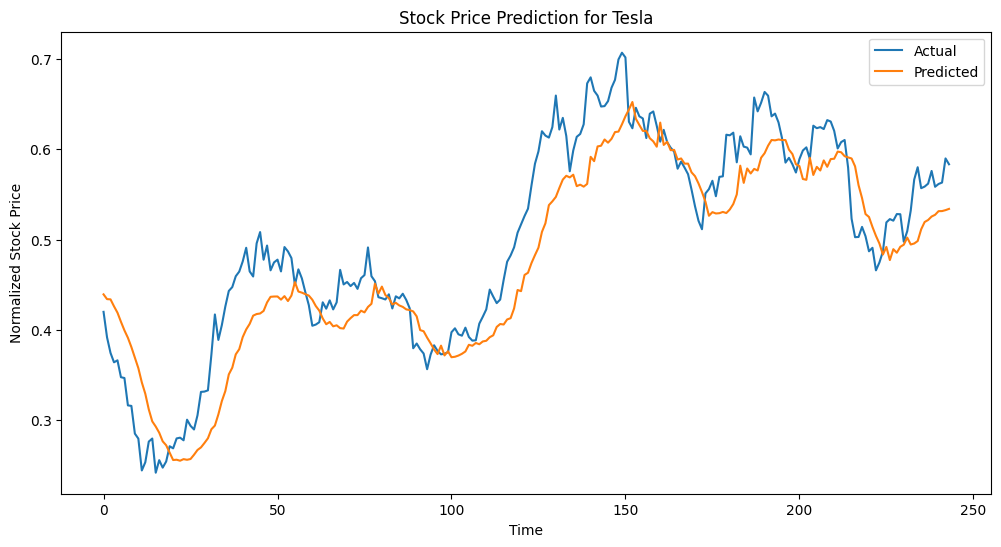

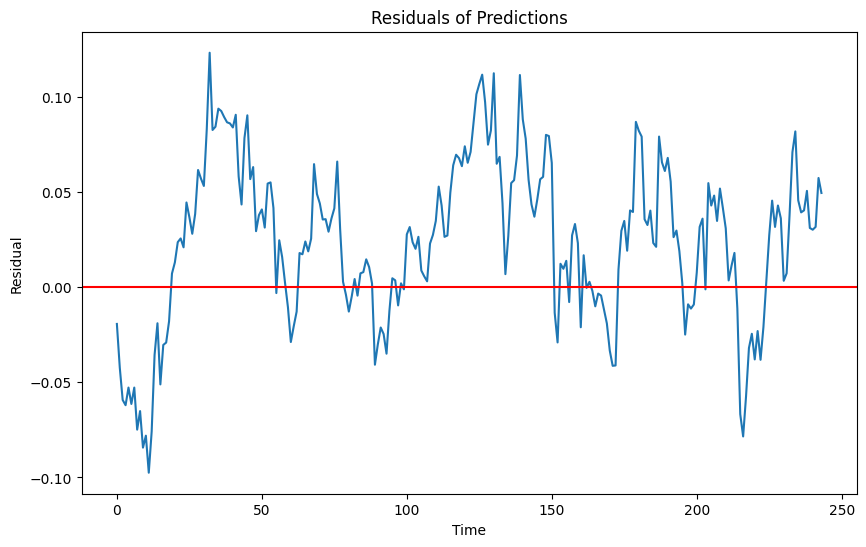

In [102]:
# Test Loss
final_test_loss = evaluate(best_model, best_test_loader, nn.MSELoss())
print(f'\n\nFinal Test Loss: {final_test_loss:.8f}')

print(f'\n\n Best R2: {best_r2}')

# Plot Actuals v Predicted 

plot_predictions1(best_model, best_test_loader)

# PLOT RESIDUALS
plot_residuals(best_model, best_test_loader)

# MAKE PREDICTIONS and EXPORT TO CSV 

predictions = predict(best_model, best_test_loader)

unscaled_predictions = best_scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()


# Inverse transform test features
# You need to correctly identify and extract 'scaled_test_features' from your dataset
# unscaled_test_features = scaler_features.inverse_transform(scaled_test_features)

# Assuming features are the original DataFrame columns without the 'Price'
feature_names = best_features.columns.tolist()

# Select the corresponding test set features from the scaled_features array
test_features = scaled_features[best_total_size - best_test_size:]

# Reverse scaling of test set features
unscaled_test_features = best_scaler_features.inverse_transform(test_features)


trimmed_test_features = unscaled_test_features[-len(unscaled_predictions):]


# Create DataFrame
pred_export = pd.DataFrame(trimmed_test_features, columns=feature_names)
pred_export['Predicted Price'] = unscaled_predictions

csv_filename = f"{stock_names[0]}_historical_predictions.csv"

# Now you can use csv_filename to save your file
pred_export.to_csv(csv_filename, index=False)